In [8]:
import os
import time
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder

%matplotlib inline
seed = 2017
path = '/Users/zhouzhirui/data/Mercari_Price_Forcast'
os.chdir(path)

train = pd.read_csv('./data/local_train.csv')
val = pd.read_csv('./data/local_val.csv')

le_brand_name = LabelEncoder()
le_brand_name.fit(np.hstack([val.brand_name.values, train.brand_name.values]))
train['brand_name'] = le_brand_name.transform(train['brand_name'])
val['brand_name'] = le_brand_name.transform(val['brand_name'])

le_category_name = LabelEncoder()
le_category_name.fit(np.hstack([val.category_name.values, train.category_name.values]))
train['category_name'] = le_category_name.transform(train['category_name'])
val['category_name'] = le_category_name.transform(val['category_name'])

In [2]:
xgb_train = xgb.DMatrix(train.drop(['name','item_description','price'], axis=1).values, 
                        train['price'].values,
                        feature_names=['item_condition_id','category_name','brand_name','shipping'])

xgb_val = xgb.DMatrix(val.drop(['name','item_description','price'], axis=1).values, 
                      val['price'].values,
                      feature_names=['item_condition_id','category_name','brand_name','shipping'])

xgb_param = {
    'eta':0.05,
    'subsample':0.7,
    'colsample_bytree':0.9,
    'colsample_bytree':0.9
}
model = xgb.train(xgb_param, xgb_train, 
                  num_boost_round=500, 
                  evals=[(xgb_val,'validation')], 
                  early_stopping_rounds=10)

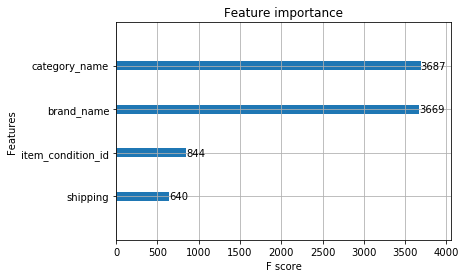

In [76]:
xgb.plot_importance(model)

In [11]:
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    y_pred[np.where(y_pred<0)] = 0
    y_log = np.log(y+1)
    y_pred_log = np.log(y_pred+1)
    score = np.sqrt(np.mean(np.square(y_log-y_pred_log)))
    return score

In [13]:
rmsle(val.price.values, model.predict(xgb_val))

0.62259372024279258